In [1]:
import glob2
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = glob2.glob("train/*")
species = []
for f in files:
    species.append(f[6:]) # birds species list

Birds information data scrap from wikipedia - to be updated

In [3]:
# # %%script false --no-raise-error # dont execute cell

# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.common.exceptions import NoSuchElementException
# import re

# webpage = r"https://en.wikipedia.org/wiki/Main_Page"

# for searchterm in species[:4]:

#     driver = webdriver.Chrome()
#     driver.minimize_window()
#     driver.get(webpage)

#     # find search-box
#     sbox = driver.find_element(By.CLASS_NAME, "vector-search-box-input")
#     try:
#         sbox.send_keys(searchterm) # write searching keywords in search-box
#         submit = driver.find_element(By.ID, "searchButton")
#         submit.click()

#         try: # if searchterm correction is available - use it
#             driver.find_element(By.XPATH, "//*[@class='mw-search-result'][1]/div[1]/a").click()
#             found = "found with 'did you mean' correction"
#         except NoSuchElementException:
#             found = "found"
        
#         # get basic information of specie
#         basic_info = driver.find_element(By.XPATH, '//*[@id="mw-content-text"]/div[1]/p[2]').text
#         # clean text
#         basic_info = re.sub('\s?\[.*?\]', '', basic_info).strip()
    
#     except NoSuchElementException:
#         found = "NOT found"

#     print("searching for", searchterm, "-", found)

#     try: # look for 'description' heading
#         driver.find_element(By.ID, "Description")
#         description = driver.find_element(By.XPATH, '//*[@id="Description"]/parent::h2/following-sibling::p').text
#         description = re.sub('\s?\[.*?\]', '', description).strip()
#     except NoSuchElementException:
#         description = ""

#     driver.close()

#     print("information sample:", basic_info[:75])
#     print("description sample:", description[:75])

Definition to create array of bird species catalogues

In [4]:
def get_species_dataset(directory, species_count = None, img_count = None):
                                # reduced number of species and images per specie
    target = []

    zero = glob2.glob(os.path.join(directory, species[0])+"/*")[0]
    zero_img = cv2.cvtColor(cv2.imread(zero),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)

    for specie in species[:species_count]:
        specie_id = species.index(specie)
        specie_imgs = glob2.glob(os.path.join(directory, specie)+"/*")

        for img in specie_imgs[:img_count]:
            tmp_img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)
            
            if specie == species[0] and img == specie_imgs[0]:
                dataset = zero_img
                
            else:
                dataset = np.concatenate((dataset, tmp_img ), axis=0)

            target.append(specie_id)
            
    target_arr = np.array(target).reshape(-1,1)

    print("            dataset shape:", dataset.shape)
    print("             target shape:", target_arr.shape)
    print("target classes and counts:", dict((i, target.count(i)) for i in target))

    return dataset, target_arr

Dataset for DL training

In [5]:
x_train, y_train = get_species_dataset("train", 5)

            dataset shape: (808, 224, 224, 3)
             target shape: (808, 1)
target classes and counts: {0: 166, 1: 180, 2: 179, 3: 137, 4: 146}


In [6]:
x_test, y_test = get_species_dataset("test", 5)

            dataset shape: (25, 224, 224, 3)
             target shape: (25, 1)
target classes and counts: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5}


In [31]:
y_test

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4],
       [4]])

In [7]:
import tensorflow as tf

In [8]:
from tensorflow.keras import layers

def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=3,
                                    strides=1,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [9]:
our_cnn = create_cnn_model(
    inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[],
    hAct='relu',
    outNum=5,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 24)        3480      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 24)       0

In [10]:
history = our_cnn.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, y_test)
)

Epoch 1/30
7/7 [==============================] - 15s 2s/step - loss: 19.5792 - accuracy: 0.2030 - val_loss: 6.3783 - val_accuracy: 0.1600
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 3.6942 - accuracy: 0.2438 - val_loss: 2.0533 - val_accuracy: 0.1200
Epoch 3/30
7/7 [==============================] - 13s 2s/step - loss: 1.7808 - accuracy: 0.2599 - val_loss: 1.5866 - val_accuracy: 0.3200
Epoch 4/30
7/7 [==============================] - 12s 2s/step - loss: 1.5428 - accuracy: 0.3156 - val_loss: 1.4177 - val_accuracy: 0.3200
Epoch 5/30
7/7 [==============================] - 11s 2s/step - loss: 1.3973 - accuracy: 0.4084 - val_loss: 1.3918 - val_accuracy: 0.4800
Epoch 6/30
7/7 [==============================] - 12s 2s/step - loss: 1.2691 - accuracy: 0.5037 - val_loss: 1.3031 - val_accuracy: 0.5200
Epoch 7/30
7/7 [==============================] - 11s 2s/step - loss: 1.1504 - accuracy: 0.5594 - val_loss: 1.1677 - val_accuracy: 0.5200
Epoch 8/30
7/7 [=================

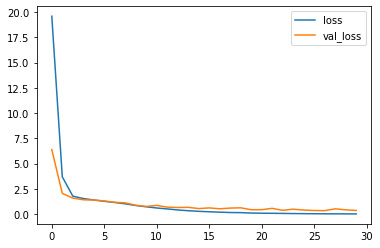

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

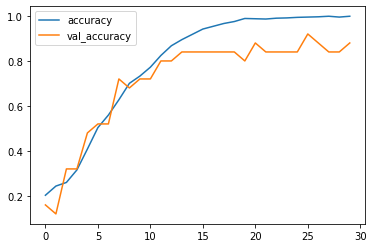

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [14]:
our_cnn.save_weights("weights/model_for_fun")

In [15]:
our_cnn.predict(x_test[:2])

array([[6.7779160e-01, 7.8586889e-03, 1.5162300e-01, 2.8803846e-04,
        1.6243868e-01],
       [6.7423600e-01, 3.2408190e-01, 7.0264134e-05, 1.6118500e-03,
        2.6033119e-08]], dtype=float32)

    inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[],
    hAct='relu',
    outNum=5,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
model_loaded = create_cnn_model(
        inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[],
    hAct='relu',
    outNum=5,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 24)        3480      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 24)      

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
y_pred = model_loaded.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5

    accuracy                           0.88        25
   macro avg       0.89      0.88      0.88        25
weighted avg       0.89      0.88      0.88        25



In [41]:
y_pred = model_loaded.predict(x_test)
print(confusion_matrix(y_test, y_pred.argmax(axis=1)))

[[4 0 0 0 1]
 [1 4 0 0 0]
 [0 0 5 0 0]
 [0 0 1 4 0]
 [0 0 0 0 5]]


In [19]:
model_loaded.load_weights("weights/model_for_fun")

In [33]:
y_pred = our_cnn.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        25
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.20        25
   macro avg       0.20      0.04      0.07        25
weighted avg       1.00      0.20      0.33        25



c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
model_loaded.predict(x_test[:2])

array([[6.7779160e-01, 7.8586889e-03, 1.5162300e-01, 2.8803846e-04,
        1.6243868e-01],
       [6.7423600e-01, 3.2408190e-01, 7.0264134e-05, 1.6118500e-03,
        2.6033119e-08]], dtype=float32)

In [22]:
our_cnn.save("model/simple.h5")

In [23]:
model_loaded_h5 = tf.keras.models.load_model("model/simple.h5")

In [24]:
y_pred = model_loaded_h5.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        25
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.20        25
   macro avg       0.20      0.04      0.07        25
weighted avg       1.00      0.20      0.33        25



c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AMD\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
model_loaded_h5.predict(x_test[:2])

array([[6.7779160e-01, 7.8586889e-03, 1.5162300e-01, 2.8803846e-04,
        1.6243868e-01],
       [6.7423600e-01, 3.2408190e-01, 7.0264134e-05, 1.6118500e-03,
        2.6033119e-08]], dtype=float32)